In [1]:
from __future__ import absolute_import
from __future__ import print_function

import os
import datetime
from shutil import copyfile

from tensorflow.keras.utils import plot_model




In [2]:
from simulation import Simulation, TrainSimulation, VanillaTrainSimulation, RNNTrainSimulation
from generator import TrafficGenerator
from memory import Memory, NormalMemory, SequenceMemory
# from model import TrainModel
from model import *
from visualization import Visualization
from utils import import_train_configuration, set_sumo, set_train_path

In [3]:



if __name__ == "__main__":

    config = import_train_configuration(config_file='training_settings.ini')
    sumo_cmd = set_sumo(config['gui'], config['sumocfg_file_name'], config['max_steps'])
    path = set_train_path(config['models_path_name'])

    

#     # SET PARAMETERS (ADD TO CONFIG LATER)
#     #TO DO: add to config files:
    sequence_length = 15
    
    #SET STATE DIMENSION PARAMETERS
    number_of_cells_per_lane = 10
    conv_state_shape = (number_of_cells_per_lane, 8, 2)
    green_phase_state_shape = 4
    elapsed_time_state_shape = 1
    state_shape = [conv_state_shape, green_phase_state_shape, elapsed_time_state_shape]
    
    
    
    
    
    

    
    

    TrafficGen = TrafficGenerator(
        config['max_steps'], 
        config['penetration_rate']
    )

    Visualization = Visualization(
        path, 
        dpi=96
    )
    
    
    #VANILLA MODEL
    if config['uses_reccurent_network'] == False:
        
        # online model used for training
        Model = VanillaTrainModel(
            config['batch_size'], 
            config['learning_rate'], 
            output_dim=config['num_actions'],
            state_shape=state_shape
        )
        Model._model.summary()
        plot_model(Model._model, 'my_first_model_with_shape_info.png', show_shapes=True)

        #target model, only used for predictions. regularly the values of Model are copied into TargetModel
        TargetModel = VanillaTrainModel(
            config['batch_size'], 
            config['learning_rate'], 
            output_dim=config['num_actions'],
            state_shape=state_shape
        )
        
        Memory = NormalMemory(
            config['memory_size_max'], 
            config['memory_size_min']
        )
        
        Simulation = VanillaTrainSimulation(
            Model,
            TargetModel,
            Memory,
            TrafficGen,
            sumo_cmd,
            config['gamma'],
            config['max_steps'],
            config['green_duration'],
            config['yellow_duration'],
            config['num_actions'],
            config['training_epochs'],
            config['copy_step']
        )

        
    #RECURRENT MODEL
    else:
            # online model used for training
        Model = RNNTrainModel(
            config['batch_size'], 
            config['learning_rate'], 
            output_dim=config['num_actions'],
            state_shape=state_shape,
            sequence_length=sequence_length, 
            statefulness = False
        )
        Model._model.summary()
        plot_model(Model._model, 'my_first_model_with_shape_info.png', show_shapes=True)


        #target model, only used for predictions. regularly the values of Model are copied into TargetModel
        TargetModel = RNNTrainModel( 
            config['batch_size'], 
            config['learning_rate'], 
            output_dim=config['num_actions'],
            state_shape=state_shape,
            sequence_length=sequence_length,
            statefulness = False
        )
        
        PredictModel = RNNTrainModel(
            config['batch_size'], 
            config['learning_rate'], 
            output_dim=config['num_actions'],
            state_shape=state_shape,
            sequence_length=sequence_length,
            statefulness = True
        )
        
        
        
        
        Memory = SequenceMemory(
            config['memory_size_max'], 
            config['memory_size_min'],
            sequence_length
        )
        
        Simulation = RNNTrainSimulation(
            Model,
            TargetModel,
            Memory,
            TrafficGen,
            sumo_cmd,
            config['gamma'],
            config['max_steps'],
            config['green_duration'],
            config['yellow_duration'],
            config['num_actions'],
            config['training_epochs'],
            config['copy_step'],
            PredictModel
        )


    
    

    
    
        
    
    
    print(' ')
    print(' ')
    print('Starting...' )
    print(' ')
    
    episode = 0
    timestamp_start = datetime.datetime.now()



    
    while episode < config['total_episodes']:
        print('\n----- Episode', str(episode+1), 'of', str(config['total_episodes']))
        
        #set epsilon
        epsilon = 1.0 - (episode / config['total_episodes'])  # set the epsilon for this episode according to epsilon-greedy policy
        
        
        #run simulation + train for one episode at a time
        simulation_time, training_time = Simulation.run(episode, epsilon)  # run the simulation
        print('Simulation time:', simulation_time, 's - Training time:', training_time, 's - Total:', round(simulation_time+training_time, 1), 's')
        episode += 1

    print("\n----- Start time:", timestamp_start)
    print("----- End time:", datetime.datetime.now())
    print("----- Session info saved at:", path)








    Model.save_model(path)

    copyfile(src='training_settings.ini', dst=os.path.join(path, 'training_settings.ini'))

    Visualization.training_save_data_and_plot(data=Simulation.reward_store, filename='reward', xlabel='Episode', ylabel='Cumulative negative reward')


Model: "simple_CNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 10, 8, 2)]   0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 4)]          0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 5, 4, 4)      36          input_1[0][0]                    
_________________________________________________________________________________________

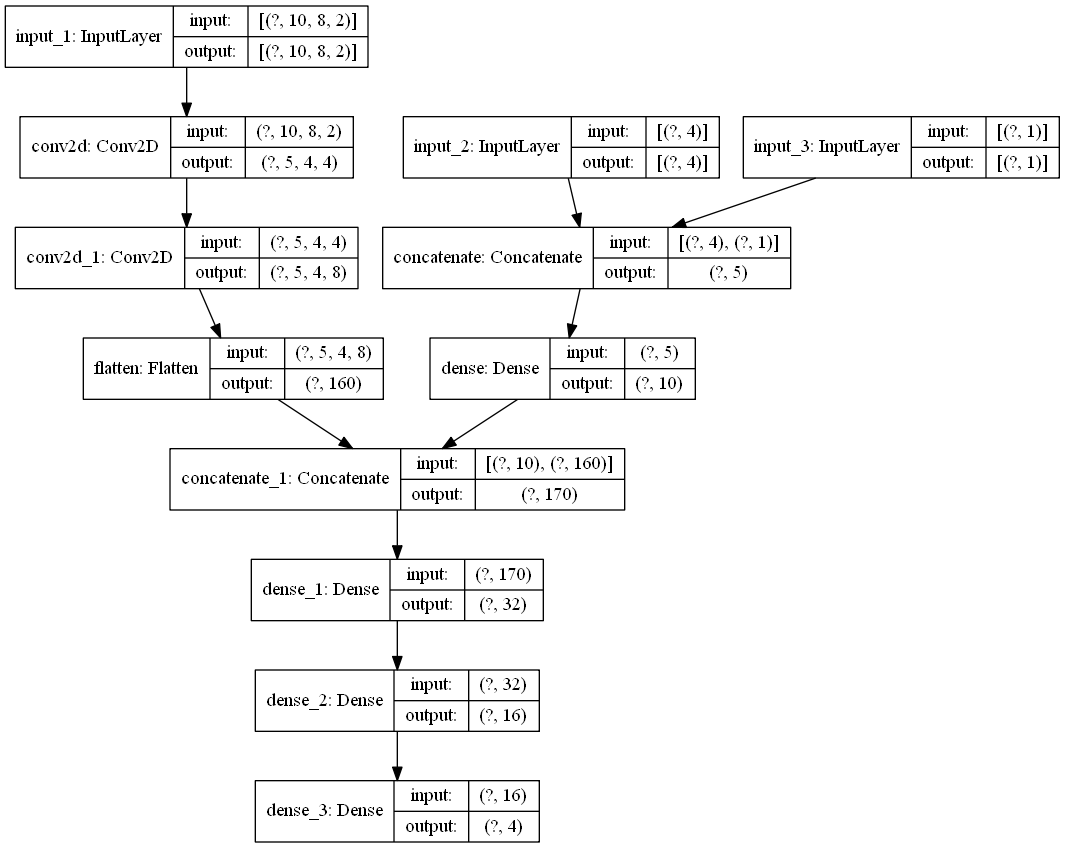

In [5]:

# plot_model(Simulation._Model._model, show_shapes=True, show_layer_names=True)